In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Add, LSTM, Activation, Flatten, Dropout, Lambda, Conv1D, Input, BatchNormalization
from keras.models import Model
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
from googlefinance.client import get_price_data, get_prices_data, get_prices_time_data
import fix_yahoo_finance as yf
%matplotlib inline

Using TensorFlow backend.


In [2]:
Stock="AAPL"
param = {
    'q': Stock, # Stock symbol (ex: "AAPL")
    'i': "86400", # Interval size in seconds ("86400" = 1 day intervals)
    # Stock exchange symbol on which stock is traded (ex: "NASD")
     'p':'5Y'# Period (Ex: "1Y" = 1 year)
}
# get price data (return pandas dataframe)
#df = get_price_data(param)
  
#df = yf.download(Stock,'2001-10-06')
#df.to_csv(Stock+'.csv')
df=pd.read_csv(Stock+'.csv')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4297,2018-07-27,194.990005,195.190002,190.100006,190.979996,190.979996,24024000
4298,2018-07-30,191.899994,192.199997,189.070007,189.910004,189.910004,21029500
4299,2018-07-31,190.300003,192.139999,189.339996,190.289993,190.289993,39373000
4300,2018-08-01,199.130005,201.759995,197.309998,201.500000,201.500000,67841600
4301,2018-08-02,200.580002,208.380005,200.350006,207.800003,207.800003,50325158


In [3]:
data=df
data['Close'].replace(0, np.nan, inplace=True)
data['Close'].fillna(method='ffill', inplace=True)

In [4]:
def Bolinger_Bands(stock_price, window_size, num_of_std):

    rolling_mean = stock_price.rolling(window=window_size).mean()
    rolling_std  = stock_price.rolling(window=window_size).std()
    upper_band = rolling_mean + (rolling_std*num_of_std)
    lower_band = rolling_mean - (rolling_std*num_of_std)

    return rolling_mean, upper_band, lower_band
Avg, Upper, Lower = Bolinger_Bands(data['Close'], 10, 2)
def OBV(data):
    last_obv = 0
    obv = [last_obv]
    for i in range(1,len(data)):
        if data['Close'][i] >= data['Close'][i-1]:
            obv.append(last_obv + data['Volume'][i])
        else:
            obv.append(last_obv - data['Volume'][i])
        last_obv = obv[-1]
    return pd.DataFrame(obv, columns=['OBV'])
def Bias(data, period=6):
    MA = data['Close'].rolling(window=period).mean()
    bias=[]
    for i in range(len(data)):
        bias.append(((data['Close'][i]-MA[i])/MA[i])*100)
    return pd.DataFrame(bias, columns=['Bias'])
def PSY(data, period=12):
    psy = [np.nan]*(period-1)
    for i in range(len(data)-period+1):
        diff = np.ediff1d(data['Close'][i:i+period])
        psy.append((len(diff[diff>=0])/len(diff))*100)
    return pd.DataFrame(psy, columns=['PSY'])
def SY(data, i, p):
    return ((data['Close'][i-p]-data['Close'][i-p-1])/data['Close'][i-p-1])*100

def ASY(data, period):
    if period == 1:
        asy = [np.nan]*2
        for i in range(2,len(data)):
            asy.append(((data['Close'][i-1]-data['Close'][i-2])/data['Close'][i-2])*100)
    else:
        asy = [np.nan]*period
        for i in range(period,len(data)):
            A=0
            for j in range(period):
                A = A + SY(data, i,j)
            A = A/(j+1)
            asy.append(A)
            
    return pd.DataFrame(asy, columns=['ASY'+str(period)])


In [6]:
from stockstats import StockDataFrame
indicators = ['close_50_sma','close_150_sma','close_20_ema','close_40_ema','boll','boll_ub','boll_lb',\
             'macd','kdjk','kdjd','kdjj','atr','adx','vr','rsi_14']
for i in indicators:
    df = StockDataFrame.retype(data)
    df = df.get(i)

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [5]:
print(data.shape)
data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()
print(data.shape)

(4302, 7)
(4302, 7)


In [8]:
diff=np.ediff1d(data.iloc[:,3])
diff.shape
Data = np.append(data.values[:-1,:], diff.reshape(-1,1), axis=1)

In [9]:
Data.shape

(4299, 57)

In [208]:
#values = data[['Weighted'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
values = data[['Open'] + ['High'] + ['Low'] + ['Close'] + ['Volume']]
# values.insert(5,'OBV',OBV(data))
# #values.insert(2,'Volume',data['Volume'])#.rolling(window=50).mean())
# values.insert(6,'MA5',data['Close'].rolling(window=5).mean())
# values.insert(7,'Bias',Bias(data,6))
# values.insert(8,'PSY12',PSY(data,12))
# values.insert(9,'ASY1',ASY(data,1))
# values.insert(10,'ASY2',ASY(data,2))
# values.insert(11,'ASY3',ASY(data,3))
# values.insert(12,'ASY4',ASY(data,4))
# values.insert(13,'ASY5',ASY(data,5))
# diff = np.ediff1d(data['Close'])
# diff=np.append(np.array([0]),diff)
# values.insert(14,'diff',diff)
#values.insert(4,'MA150',data['Close'].rolling(window=150).mean())
#values.insert(5, 'EMA20', data['Close'].ewm(span=20, adjust=False).mean())
#values.insert(13, 'Lower', Lower)
#values.insert(14, 'Avg', Avg)
#values.insert(15, 'Upper', Upper)
#values.insert(5,'open', data['Open'])
#values=values.iloc[:,1:]
values.dropna(inplace=True)
#values=values.values
values = values.astype('float32')

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [9]:
values.head()

,Open,High,Low,Close,Volume,OBV,MA5,Bias,PSY12,ASY1,ASY2,ASY3,ASY4,ASY5
11,1.723571,1.786429,1.702857,1.775000,113685600.0,244389600.0,1.651286,8.341811,54.545456,8.074534,5.043014,5.569515,2.459068,2.575527
12,1.777143,1.792857,1.707857,1.711429,69666800.0,174722800.0,1.669286,3.016857,45.454544,2.011494,-0.784985,2.168188,3.281770,1.250962
13,1.712857,1.801429,1.643571,1.792857,161957600.0,336680384.0,1.725857,6.093684,54.545456,-3.581465,0.588215,1.062642,2.815615,3.576995
14,1.555714,1.627143,1.458571,1.485000,284253184.0,52427200.0,1.700857,-11.906782,45.454544,4.757895,-6.206707,-5.331626,-3.495846,-1.181770
15,1.516429,1.530000,1.410714,1.425714,215284992.0,-162857792.0,1.638000,-13.854139,45.454544,-17.171309,-10.581816,-5.468579,-4.996800,-3.595141


In [176]:
#values = data.iloc[1:,:]
values = values.values
#values = Data
#values = values[~np.isnan(values).any(axis=1)]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
scaled = scaler.transform(values)
#scaler = StandardScaler()
#scaler.fit(values)
#scaled = scaler.transform(values)
#scaled = normalize(values, norm='l2',axis=0)
#scaled = scale(values)

In [219]:
scaled = (values.values[:-1,:]/values.values[1:,:])
scaled = pd.DataFrame(scaled)
#scaled.replace([np.inf, -np.inf], np.nan)
#scaled = scaled.dropna()
all_inf_or_nan = scaled.isin([np.inf, -np.inf, np.nan]).all(axis='columns')
scaled = scaled[~all_inf_or_nan]
scaled = scaled.values

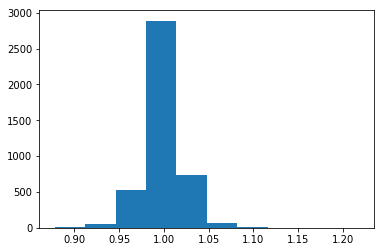

In [220]:
import matplotlib.pyplot as plt
plt.hist(scaled[:,3])
plt.show()

In [102]:
scaled.mean(axis=0)

array([ 0.25725883,  0.24984172,  0.25506976,  0.2482361 ,  0.13409345], dtype=float32)

In [22]:
scaled.shape

(4291, 14)

In [11]:
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.utils import shuffle
data_gen = TimeseriesGenerator(scaled[:4000], scaled[:4000,-1],
                               length=5, sampling_rate=1,
                               stride=1, batch_size=len(scaled[:4000]))
X, y = data_gen[0]
#X, y = shuffle(X, y, random_state = 0)
print(X.shape, y.shape)
data_gen2 = TimeseriesGenerator(scaled[4000:], scaled[4000:,-1],
                               length=5, sampling_rate=1,
                               stride=1, batch_size=len(scaled[4000:]),shuffle=False)
test_X, test_y = data_gen2[0]
#test_X, test_y = shuffle(test_X, test_y, random_state = 0)
test_X.shape, test_y.shape

(3994, 5, 11) (3994,)


((147, 5, 11), (147,))

In [15]:
y = np.ediff1d(scaled[:4000,-1])
print(y.shape)
data_gen = TimeseriesGenerator(y, y,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=len(scaled[:4000]))
y_seq,_ = data_gen[0]
print(y_seq.shape)

test_y = np.ediff1d(scaled[4000:,-1])
print(test_y.shape)
data_gen = TimeseriesGenerator(test_y, test_y,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=len(scaled[4000:]))
test_y_seq,_ = data_gen[0]
print(test_y_seq.shape)

(3999,)
(3993, 5)
(152,)
(146, 5)


In [99]:
#y = np.ediff1d(scaled[19:4000,-1])
y=y_seq
X = X[:-1]
#y = y[:-(len(y)-len(X))]
y1 = np.empty([len(y),y.shape[1]], dtype=np.float32)
for i in range(len(y)):
    for j in range(y.shape[1]):
        if y[i,j] >= 0:
            y1[i,j] = 1.0
        else:
            y1[i,j] = 0.0
print(X.shape, y1.shape)

#test_y = np.ediff1d(scaled[4019:,-1])
test_y=test_y_seq
test_X = test_X[:-1]
#test_y = test_y[:-(len(test_y)-len(test_X))]
test_y1 = np.empty([len(test_y),test_y.shape[1]], dtype=np.float32)
for i in range(len(test_y)):
    for j in range(test_y.shape[1]):
        if test_y[i,j] >= 0:
            test_y1[i,j] = 1.0
        else:
            test_y1[i,j] = 0.0
print(test_X.shape, test_y1.shape)

(3958, 40, 11) (3958, 40)
(111, 40, 11) (111, 40)


Make sequence and then train valid and test

In [127]:
y = np.ediff1d(s[:,3])
y

array([  6.90603629e-05,  -1.00138597e-04,   2.24443153e-04, ...,
         5.41905165e-02,   3.04549336e-02,  -1.00000000e+00])

In [129]:
s=np.append(scaled, np.zeros((1,scaled.shape[1])),axis=0)
print(s.shape)
print(scaled.shape)

(4303, 5)
(4302, 5)


In [336]:
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.utils import shuffle
#scaled=values
scaled2=scaled.copy()
#scaled=scaled[:-15]
s=np.append(scaled, np.zeros((1,scaled.shape[1])),axis=0)
data_gen = TimeseriesGenerator(scaled[:], scaled[:,3],
                               length=15, sampling_rate=1,
                               stride=1, batch_size=len(s-1))
X, y = data_gen[0]
print(X.shape, y.shape)
y = np.ediff1d(scaled[:,3])
print(y.shape)
data_gen = TimeseriesGenerator(y, y,
                              length=15, sampling_rate=1,
                              stride=1, batch_size=len(y))
_, y_seq = data_gen[0]
print(y_seq.shape)
y=y_seq
X = X[:-1]
print(X.shape, y.shape)
y1 = np.empty([len(y)], dtype=np.float32)
for i in range(len(y)):
    if y[i] >= 0.0:
        y1[i] = 1.0
    else:
        y1[i] = 0.0

#scaler = MinMaxScaler(feature_range=(0, 1))
print(y1.shape)
#y1=y1[:,-1]
y1=to_categorical(y1)
print(y1.shape)
# scaler = StandardScaler()
#scaler.fit(y.reshape(-1, 1))
#y1 = scaler.transform(y.reshape(-1, 1))
# #y1 = scale(y)
# print(X.shape, y1.shape)
#y1=y1*20
#y1=y
#X, y1 = shuffle(X, y1, random_state = 0)
train_X = X[:-20]
train_y = y1[:-20]
train_X, train_y = shuffle(train_X, train_y, random_state = 1)
valid_X = X[3500:3800]
valid_y = y1[3500:3800]
test_X = X[-20:]
test_y = y1[-20:]
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)

(4275, 25, 5) (4275,)
(4300,)
(4274,)
(4274, 25, 5) (4274,)
(4274,)
(4274, 2)
(4254, 25, 5) (4254, 2) (300, 25, 5) (300, 2) (20, 25, 5) (20, 2)


In [245]:
train_X.reshape(4281,75).shape

(4281, 75)

In [318]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=250, max_depth=80,random_state=0)
clf.fit(train_X.reshape(4281,75), train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [319]:
clf.predict(test_X.reshape(3,75))

array([ 1.,  0.,  1.], dtype=float32)

In [320]:
test_y

array([ 0.,  0.,  0.], dtype=float32)

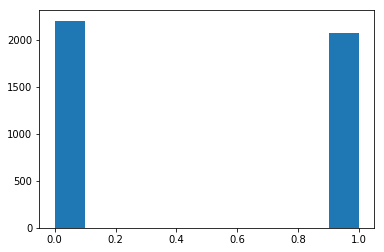

In [52]:
from keras.utils import to_categorical
plt.hist(to_categorical(y1)[:,0])
plt.show()

In [21]:
# X = scaled[:14].reshape(1,14,8)
# y = scaled[28,-1]
# for i in range(1,500):
#     if 14*(i+2)<len(scaled):
#         X = np.append(X, scaled[(14*(i)):(14*(i+1)),:].reshape(1,14,8), axis=0)
#         y = np.append(y, scaled[14*(i+2),-1])
# X.shape, y.shape
#scaled2=scaled
#scaled=scaled[:-15]
X = scaled[-16:-1,:].reshape(1,15,56)
y = scaled[-1,3]-scaled[-2,3]
for i in range(1,4127):
    X = np.append(X, scaled[-16-i:-1-i,:].reshape(1,15,56),axis=0)
    y = np.append(y, scaled[-1-i,3]-scaled[-2-i,3])
y1 = np.empty([len(y)], dtype=np.float32)
for i in range(len(y)):
    if y[i] >= 0:
        y1[i] = 1.0
    else:
        y1[i] = -1.0
print(X.shape,y1.shape)

(4127, 15, 56) (4127,)


In [11]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(scaled[:,:-1], scaled[:,-1], test_size=0.02, shuffle=False)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4204, 14) (4204,) (86, 14) (86,)


In [22]:
from sklearn.utils import shuffle
X, y1 = shuffle(X, y1, random_state = 0)

In [39]:
y1 = np.empty([len(y)], dtype=np.float32)
for i in range(len(y)):
    if y[i] >= 0:
        y1[i] = 1.0
    else:
        y1[i] = 0.0

In [342]:
from keras.callbacks import ReduceLROnPlateau
from keras import metrics
from keras.initializers import he_normal, lecun_normal
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
def custom_activation(x):
    return (K.sigmoid(x*10)) 

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def tcn(h,filters=500, kernel_size=3, padding='causal', activation='relu', dilation_rate=1):
    main = BatchNormalization()(h)
    main = h
    init = lecun_normal(seed=1)
    for i in range(1):
        main = Conv1D(filters=filters,kernel_size=kernel_size,padding=padding, dilation_rate=dilation_rate, kernel_initializer=init)(main)
        main = Activation('relu')(main)
        main = BatchNormalization()(main)       
        main = Dropout(0.25)(main)
    side_path = Conv1D(filters=filters,kernel_size=1, padding='same', kernel_initializer=init)(h)
    #side_path = BatchNormalization()(side_path)
    return Add()([main,side_path])

Inp = Input(shape=(15,5))
inp = Inp
D = [1,2,4,1,1]
for i in range(3):
    inp=tcn(inp,dilation_rate=D[i])
    #inp = BatchNormalization()(inp)
    #inp = Activation('relu')(inp)
inp=Flatten()(inp)
init = lecun_normal(seed=1)
inp=Dense(100)(inp)
inp = Activation('relu')(inp)
inp = BatchNormalization()(inp)
inp = Dropout(0.25)(inp)
inp=Dense(10)(inp)
inp = Activation('relu')(inp)
inp = BatchNormalization()(inp)
#inp = Dropout(0.25)(inp)
out=Dense(2,activation='softmax')(inp)
#inp = Lambda(lambda x: x * 2)(inp)
#inp = Lambda(lambda x: x/100)(inp)
model = Model(Inp,out)
ad = optimizers.Adam(lr=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8)
model.compile(loss='categorical_crossentropy', optimizer=ad, metrics=['accuracy'])
history = model.fit(train_X, train_y, epochs=50, batch_size=128, verbose=1, shuffle=True)


Epoch 1/50
4254/4254 [==============================] - 20s 5ms/step - loss: 0.7844 - acc: 0.5035
Epoch 2/50
4254/4254 [==============================] - 4s 879us/step - loss: 0.7207 - acc: 0.5160
Epoch 3/50
4254/4254 [==============================] - 4s 888us/step - loss: 0.7033 - acc: 0.5336
Epoch 4/50
4254/4254 [==============================] - 4s 880us/step - loss: 0.7018 - acc: 0.5219
Epoch 5/50
4254/4254 [==============================] - 4s 884us/step - loss: 0.6959 - acc: 0.5378
Epoch 6/50
4254/4254 [==============================] - 4s 882us/step - loss: 0.6944 - acc: 0.5435
Epoch 7/50
4254/4254 [==============================] - 4s 879us/step - loss: 0.6899 - acc: 0.5531
Epoch 8/50
4254/4254 [==============================] - 4s 872us/step - loss: 0.6949 - acc: 0.5383
Epoch 9/50
4254/4254 [==============================] - 4s 895us/step - loss: 0.6924 - acc: 0.5442
Epoch 10/50
4254/4254 [==============================] - 4s 882us/step - loss: 0.6898 - acc: 0.5456
Epoch 11/5

In [139]:
model.optimizer.lr = 0.00002
history = model.fit(train_X, train_y, epochs=1000, batch_size=128, validation_split=0.1, verbose=1, shuffle=True)


Train on 3784 samples, validate on 421 samples
Epoch 1/1000
3784/3784 [==============================] - 1s 235us/step - loss: 0.6903 - acc: 0.5285 - val_loss: 0.6915 - val_acc: 0.5392
Epoch 2/1000
3784/3784 [==============================] - 1s 237us/step - loss: 0.6910 - acc: 0.5280 - val_loss: 0.6910 - val_acc: 0.5416
Epoch 3/1000
3784/3784 [==============================] - 1s 233us/step - loss: 0.6894 - acc: 0.5254 - val_loss: 0.6906 - val_acc: 0.5487
Epoch 4/1000
3784/3784 [==============================] - 1s 235us/step - loss: 0.6894 - acc: 0.5262 - val_loss: 0.6916 - val_acc: 0.5368
Epoch 5/1000
3784/3784 [==============================] - 1s 234us/step - loss: 0.6895 - acc: 0.5307 - val_loss: 0.6916 - val_acc: 0.5321
Epoch 6/1000
3784/3784 [==============================] - 1s 234us/step - loss: 0.6910 - acc: 0.5246 - val_loss: 0.6917 - val_acc: 0.5321
Epoch 7/1000
3784/3784 [==============================] - 1s 234us/step - loss: 0.6923 - acc: 0.5206 - val_loss: 0.6906 - val

3784/3784 [==============================] - 1s 230us/step - loss: 0.6826 - acc: 0.5404 - val_loss: 0.6995 - val_acc: 0.5416
Epoch 60/1000
3784/3784 [==============================] - 1s 229us/step - loss: 0.6873 - acc: 0.5349 - val_loss: 0.6973 - val_acc: 0.5321
Epoch 61/1000
3784/3784 [==============================] - 1s 240us/step - loss: 0.6830 - acc: 0.5314 - val_loss: 0.6939 - val_acc: 0.5463
Epoch 62/1000
3784/3784 [==============================] - 1s 231us/step - loss: 0.6860 - acc: 0.5391 - val_loss: 0.6924 - val_acc: 0.5439
Epoch 63/1000
3784/3784 [==============================] - 1s 239us/step - loss: 0.6838 - acc: 0.5375 - val_loss: 0.6929 - val_acc: 0.5416
Epoch 64/1000
3784/3784 [==============================] - 1s 231us/step - loss: 0.6827 - acc: 0.5330 - val_loss: 0.6967 - val_acc: 0.5368
Epoch 65/1000
3784/3784 [==============================] - 1s 234us/step - loss: 0.6875 - acc: 0.5322 - val_loss: 0.6957 - val_acc: 0.5439
Epoch 66/1000
3784/3784 [================

Epoch 118/1000
3784/3784 [==============================] - 1s 230us/step - loss: 0.6699 - acc: 0.5462 - val_loss: 0.7030 - val_acc: 0.5226
Epoch 119/1000
3784/3784 [==============================] - 1s 231us/step - loss: 0.6675 - acc: 0.5481 - val_loss: 0.7025 - val_acc: 0.5273
Epoch 120/1000
3784/3784 [==============================] - 1s 231us/step - loss: 0.6744 - acc: 0.5513 - val_loss: 0.7047 - val_acc: 0.5321
Epoch 121/1000
3784/3784 [==============================] - 1s 229us/step - loss: 0.6645 - acc: 0.5579 - val_loss: 0.7063 - val_acc: 0.5297
Epoch 122/1000
3784/3784 [==============================] - 1s 229us/step - loss: 0.6710 - acc: 0.5566 - val_loss: 0.7102 - val_acc: 0.5202
Epoch 123/1000
3784/3784 [==============================] - 1s 229us/step - loss: 0.6643 - acc: 0.5544 - val_loss: 0.7076 - val_acc: 0.5392
Epoch 124/1000
3784/3784 [==============================] - 1s 229us/step - loss: 0.6668 - acc: 0.5507 - val_loss: 0.7092 - val_acc: 0.5273
Epoch 125/1000
3784/

3784/3784 [==============================] - 1s 227us/step - loss: 0.6435 - acc: 0.5846 - val_loss: 0.7257 - val_acc: 0.5416
Epoch 177/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.6496 - acc: 0.5748 - val_loss: 0.7232 - val_acc: 0.5321
Epoch 178/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.6465 - acc: 0.5785 - val_loss: 0.7275 - val_acc: 0.5202
Epoch 179/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.6464 - acc: 0.5751 - val_loss: 0.7295 - val_acc: 0.5297
Epoch 180/1000
3784/3784 [==============================] - 1s 228us/step - loss: 0.6488 - acc: 0.5737 - val_loss: 0.7296 - val_acc: 0.5154
Epoch 181/1000
3784/3784 [==============================] - 1s 236us/step - loss: 0.6447 - acc: 0.5827 - val_loss: 0.7281 - val_acc: 0.5178
Epoch 182/1000
3784/3784 [==============================] - 1s 241us/step - loss: 0.6442 - acc: 0.5835 - val_loss: 0.7310 - val_acc: 0.5154
Epoch 183/1000
3784/3784 [=========

3784/3784 [==============================] - 1s 228us/step - loss: 0.6237 - acc: 0.5933 - val_loss: 0.7779 - val_acc: 0.5249
Epoch 235/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.6261 - acc: 0.5973 - val_loss: 0.7703 - val_acc: 0.5273
Epoch 236/1000
3784/3784 [==============================] - 1s 225us/step - loss: 0.6216 - acc: 0.5965 - val_loss: 0.7796 - val_acc: 0.5012
Epoch 237/1000
3784/3784 [==============================] - 1s 228us/step - loss: 0.6148 - acc: 0.6033 - val_loss: 0.7788 - val_acc: 0.5273
Epoch 238/1000
3784/3784 [==============================] - 1s 232us/step - loss: 0.6226 - acc: 0.5928 - val_loss: 0.7683 - val_acc: 0.5297
Epoch 239/1000
3784/3784 [==============================] - 1s 226us/step - loss: 0.6184 - acc: 0.6012 - val_loss: 0.7668 - val_acc: 0.5297
Epoch 240/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.6162 - acc: 0.6081 - val_loss: 0.7754 - val_acc: 0.5321
Epoch 241/1000
3784/3784 [=========

3784/3784 [==============================] - 1s 228us/step - loss: 0.5962 - acc: 0.6152 - val_loss: 0.7993 - val_acc: 0.5202
Epoch 293/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.6030 - acc: 0.6197 - val_loss: 0.7951 - val_acc: 0.5178
Epoch 294/1000
3784/3784 [==============================] - 1s 228us/step - loss: 0.5964 - acc: 0.6181 - val_loss: 0.7959 - val_acc: 0.5321
Epoch 295/1000
3784/3784 [==============================] - 1s 231us/step - loss: 0.5963 - acc: 0.6202 - val_loss: 0.8021 - val_acc: 0.5273
Epoch 296/1000
3784/3784 [==============================] - 1s 242us/step - loss: 0.5964 - acc: 0.6210 - val_loss: 0.8090 - val_acc: 0.5297
Epoch 297/1000
3784/3784 [==============================] - 1s 232us/step - loss: 0.5983 - acc: 0.6155 - val_loss: 0.7909 - val_acc: 0.5249
Epoch 298/1000
3784/3784 [==============================] - 1s 242us/step - loss: 0.6001 - acc: 0.6245 - val_loss: 0.7883 - val_acc: 0.5344
Epoch 299/1000
3784/3784 [=========

3784/3784 [==============================] - 1s 224us/step - loss: 0.5870 - acc: 0.6218 - val_loss: 0.8267 - val_acc: 0.5273
Epoch 351/1000
3784/3784 [==============================] - 1s 225us/step - loss: 0.5825 - acc: 0.6239 - val_loss: 0.8263 - val_acc: 0.5249
Epoch 352/1000
3784/3784 [==============================] - 1s 232us/step - loss: 0.5785 - acc: 0.6258 - val_loss: 0.8290 - val_acc: 0.5178
Epoch 353/1000
3784/3784 [==============================] - 1s 225us/step - loss: 0.5749 - acc: 0.6369 - val_loss: 0.8382 - val_acc: 0.5273
Epoch 354/1000
3784/3784 [==============================] - 1s 226us/step - loss: 0.5733 - acc: 0.6374 - val_loss: 0.8281 - val_acc: 0.5321
Epoch 355/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.5770 - acc: 0.6356 - val_loss: 0.8490 - val_acc: 0.5178
Epoch 356/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.5760 - acc: 0.6284 - val_loss: 0.8351 - val_acc: 0.5226
Epoch 357/1000
3784/3784 [=========

3784/3784 [==============================] - 1s 225us/step - loss: 0.5601 - acc: 0.6398 - val_loss: 0.8716 - val_acc: 0.5273
Epoch 409/1000
3784/3784 [==============================] - 1s 226us/step - loss: 0.5633 - acc: 0.6411 - val_loss: 0.8682 - val_acc: 0.5368
Epoch 410/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.5671 - acc: 0.6350 - val_loss: 0.8770 - val_acc: 0.5178
Epoch 411/1000
3784/3784 [==============================] - 1s 224us/step - loss: 0.5684 - acc: 0.6403 - val_loss: 0.8650 - val_acc: 0.5416
Epoch 412/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.5613 - acc: 0.6477 - val_loss: 0.8655 - val_acc: 0.5511
Epoch 413/1000
3784/3784 [==============================] - 1s 226us/step - loss: 0.5565 - acc: 0.6419 - val_loss: 0.8622 - val_acc: 0.5487
Epoch 414/1000
3784/3784 [==============================] - 1s 229us/step - loss: 0.5550 - acc: 0.6422 - val_loss: 0.8653 - val_acc: 0.5416
Epoch 415/1000
3784/3784 [=========

3784/3784 [==============================] - 1s 226us/step - loss: 0.5444 - acc: 0.6567 - val_loss: 0.9071 - val_acc: 0.5321
Epoch 467/1000
3784/3784 [==============================] - 1s 225us/step - loss: 0.5453 - acc: 0.6501 - val_loss: 0.9223 - val_acc: 0.5273
Epoch 468/1000
3784/3784 [==============================] - 1s 226us/step - loss: 0.5394 - acc: 0.6517 - val_loss: 0.9045 - val_acc: 0.5344
Epoch 469/1000
3784/3784 [==============================] - 1s 224us/step - loss: 0.5398 - acc: 0.6564 - val_loss: 0.9006 - val_acc: 0.5297
Epoch 470/1000
3784/3784 [==============================] - 1s 225us/step - loss: 0.5423 - acc: 0.6498 - val_loss: 0.9008 - val_acc: 0.5273
Epoch 471/1000
3784/3784 [==============================] - 1s 225us/step - loss: 0.5427 - acc: 0.6501 - val_loss: 0.8819 - val_acc: 0.5273
Epoch 472/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.5496 - acc: 0.6469 - val_loss: 0.8943 - val_acc: 0.5273
Epoch 473/1000
3784/3784 [=========

3784/3784 [==============================] - 1s 226us/step - loss: 0.5316 - acc: 0.6628 - val_loss: 0.9423 - val_acc: 0.5297
Epoch 525/1000
3784/3784 [==============================] - 1s 226us/step - loss: 0.5284 - acc: 0.6609 - val_loss: 0.9428 - val_acc: 0.5344
Epoch 526/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.5376 - acc: 0.6522 - val_loss: 0.9432 - val_acc: 0.5226
Epoch 527/1000
3784/3784 [==============================] - 1s 224us/step - loss: 0.5310 - acc: 0.6578 - val_loss: 0.9406 - val_acc: 0.5249
Epoch 528/1000
3784/3784 [==============================] - 1s 226us/step - loss: 0.5388 - acc: 0.6578 - val_loss: 0.9228 - val_acc: 0.5297
Epoch 529/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.5358 - acc: 0.6557 - val_loss: 0.9343 - val_acc: 0.5321
Epoch 530/1000
3784/3784 [==============================] - 1s 224us/step - loss: 0.5371 - acc: 0.6546 - val_loss: 0.9436 - val_acc: 0.5344
Epoch 531/1000
3784/3784 [=========

3784/3784 [==============================] - 1s 225us/step - loss: 0.5225 - acc: 0.6625 - val_loss: 0.9702 - val_acc: 0.5534
Epoch 583/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.5157 - acc: 0.6657 - val_loss: 0.9855 - val_acc: 0.5487
Epoch 584/1000
3784/3784 [==============================] - 1s 224us/step - loss: 0.5213 - acc: 0.6718 - val_loss: 0.9869 - val_acc: 0.5392
Epoch 585/1000
3784/3784 [==============================] - 1s 224us/step - loss: 0.5132 - acc: 0.6784 - val_loss: 0.9898 - val_acc: 0.5439
Epoch 586/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.5176 - acc: 0.6691 - val_loss: 0.9961 - val_acc: 0.5463
Epoch 587/1000
3784/3784 [==============================] - 1s 225us/step - loss: 0.5253 - acc: 0.6652 - val_loss: 0.9608 - val_acc: 0.5439
Epoch 588/1000
3784/3784 [==============================] - 1s 226us/step - loss: 0.5234 - acc: 0.6670 - val_loss: 0.9639 - val_acc: 0.5226
Epoch 589/1000
3784/3784 [=========

3784/3784 [==============================] - 1s 225us/step - loss: 0.5103 - acc: 0.6736 - val_loss: 1.0175 - val_acc: 0.5249
Epoch 641/1000
3784/3784 [==============================] - 1s 226us/step - loss: 0.5098 - acc: 0.6686 - val_loss: 1.0120 - val_acc: 0.5202
Epoch 642/1000
3784/3784 [==============================] - 1s 226us/step - loss: 0.5094 - acc: 0.6739 - val_loss: 1.0257 - val_acc: 0.5344
Epoch 643/1000
3784/3784 [==============================] - 1s 225us/step - loss: 0.5184 - acc: 0.6715 - val_loss: 1.0050 - val_acc: 0.5249
Epoch 644/1000
3784/3784 [==============================] - 1s 226us/step - loss: 0.5054 - acc: 0.6789 - val_loss: 1.0298 - val_acc: 0.5344
Epoch 645/1000
3784/3784 [==============================] - 1s 235us/step - loss: 0.5138 - acc: 0.6686 - val_loss: 1.0133 - val_acc: 0.5321
Epoch 646/1000
3784/3784 [==============================] - 1s 225us/step - loss: 0.5051 - acc: 0.6718 - val_loss: 1.0236 - val_acc: 0.5368
Epoch 647/1000
3784/3784 [=========

3784/3784 [==============================] - 1s 229us/step - loss: 0.4922 - acc: 0.6834 - val_loss: 1.0610 - val_acc: 0.5416
Epoch 699/1000
3784/3784 [==============================] - 1s 234us/step - loss: 0.4941 - acc: 0.6818 - val_loss: 1.0540 - val_acc: 0.5202
Epoch 700/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.4977 - acc: 0.6882 - val_loss: 1.0590 - val_acc: 0.5226
Epoch 701/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.5001 - acc: 0.6853 - val_loss: 1.0524 - val_acc: 0.5392
Epoch 702/1000
3784/3784 [==============================] - 1s 225us/step - loss: 0.4968 - acc: 0.6839 - val_loss: 1.0495 - val_acc: 0.5487
Epoch 703/1000
3784/3784 [==============================] - 1s 226us/step - loss: 0.4936 - acc: 0.6818 - val_loss: 1.0645 - val_acc: 0.5344
Epoch 704/1000
3784/3784 [==============================] - 1s 224us/step - loss: 0.5031 - acc: 0.6871 - val_loss: 1.0683 - val_acc: 0.5439
Epoch 705/1000
3784/3784 [=========

3784/3784 [==============================] - 1s 234us/step - loss: 0.4875 - acc: 0.6842 - val_loss: 1.0854 - val_acc: 0.5368
Epoch 757/1000
3784/3784 [==============================] - 1s 231us/step - loss: 0.4817 - acc: 0.6942 - val_loss: 1.0949 - val_acc: 0.5344
Epoch 758/1000
3784/3784 [==============================] - 1s 230us/step - loss: 0.4803 - acc: 0.6987 - val_loss: 1.1131 - val_acc: 0.5392
Epoch 759/1000
3784/3784 [==============================] - 1s 232us/step - loss: 0.4823 - acc: 0.6908 - val_loss: 1.0858 - val_acc: 0.5392
Epoch 760/1000
3784/3784 [==============================] - 1s 232us/step - loss: 0.4812 - acc: 0.6834 - val_loss: 1.0795 - val_acc: 0.5321
Epoch 761/1000
3784/3784 [==============================] - 1s 230us/step - loss: 0.4941 - acc: 0.6932 - val_loss: 1.0452 - val_acc: 0.5321
Epoch 762/1000
3784/3784 [==============================] - 1s 234us/step - loss: 0.4856 - acc: 0.6895 - val_loss: 1.0645 - val_acc: 0.5368
Epoch 763/1000
3784/3784 [=========

3784/3784 [==============================] - 1s 233us/step - loss: 0.4646 - acc: 0.7064 - val_loss: 1.0953 - val_acc: 0.5416
Epoch 815/1000
3784/3784 [==============================] - 1s 231us/step - loss: 0.4655 - acc: 0.7014 - val_loss: 1.1162 - val_acc: 0.5321
Epoch 816/1000
3784/3784 [==============================] - 1s 232us/step - loss: 0.4869 - acc: 0.6908 - val_loss: 1.1152 - val_acc: 0.5392
Epoch 817/1000
3784/3784 [==============================] - 1s 232us/step - loss: 0.4651 - acc: 0.6995 - val_loss: 1.1216 - val_acc: 0.5321
Epoch 818/1000
3784/3784 [==============================] - 1s 231us/step - loss: 0.4750 - acc: 0.6927 - val_loss: 1.1217 - val_acc: 0.5487
Epoch 819/1000
3784/3784 [==============================] - 1s 230us/step - loss: 0.4702 - acc: 0.6903 - val_loss: 1.0929 - val_acc: 0.5321
Epoch 820/1000
3784/3784 [==============================] - 1s 233us/step - loss: 0.4690 - acc: 0.7027 - val_loss: 1.0938 - val_acc: 0.5392
Epoch 821/1000
3784/3784 [=========

3784/3784 [==============================] - 1s 225us/step - loss: 0.4577 - acc: 0.7170 - val_loss: 1.1320 - val_acc: 0.5511
Epoch 873/1000
3784/3784 [==============================] - 1s 225us/step - loss: 0.4643 - acc: 0.7045 - val_loss: 1.1289 - val_acc: 0.5582
Epoch 874/1000
3784/3784 [==============================] - 1s 224us/step - loss: 0.4634 - acc: 0.7096 - val_loss: 1.1342 - val_acc: 0.5534
Epoch 875/1000
3784/3784 [==============================] - 1s 225us/step - loss: 0.4637 - acc: 0.7040 - val_loss: 1.1411 - val_acc: 0.5534
Epoch 876/1000
3784/3784 [==============================] - 1s 228us/step - loss: 0.4621 - acc: 0.7024 - val_loss: 1.1565 - val_acc: 0.5534
Epoch 877/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.4599 - acc: 0.7112 - val_loss: 1.1541 - val_acc: 0.5487
Epoch 878/1000
3784/3784 [==============================] - 1s 226us/step - loss: 0.4555 - acc: 0.7119 - val_loss: 1.1309 - val_acc: 0.5439
Epoch 879/1000
3784/3784 [=========

3784/3784 [==============================] - 1s 224us/step - loss: 0.4552 - acc: 0.7101 - val_loss: 1.1691 - val_acc: 0.5463
Epoch 931/1000
3784/3784 [==============================] - 1s 225us/step - loss: 0.4562 - acc: 0.7151 - val_loss: 1.1745 - val_acc: 0.5463
Epoch 932/1000
3784/3784 [==============================] - 1s 224us/step - loss: 0.4548 - acc: 0.7090 - val_loss: 1.1293 - val_acc: 0.5487
Epoch 933/1000
3784/3784 [==============================] - 1s 224us/step - loss: 0.4643 - acc: 0.7035 - val_loss: 1.1450 - val_acc: 0.5606
Epoch 934/1000
3784/3784 [==============================] - 1s 225us/step - loss: 0.4517 - acc: 0.7067 - val_loss: 1.1397 - val_acc: 0.5558
Epoch 935/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.4628 - acc: 0.7093 - val_loss: 1.1412 - val_acc: 0.5534
Epoch 936/1000
3784/3784 [==============================] - 1s 227us/step - loss: 0.4524 - acc: 0.7125 - val_loss: 1.1540 - val_acc: 0.5439
Epoch 937/1000
3784/3784 [=========

3784/3784 [==============================] - 1s 225us/step - loss: 0.4483 - acc: 0.7093 - val_loss: 1.1821 - val_acc: 0.5487
Epoch 989/1000
3784/3784 [==============================] - 1s 224us/step - loss: 0.4537 - acc: 0.7125 - val_loss: 1.1588 - val_acc: 0.5344
Epoch 990/1000
3784/3784 [==============================] - 1s 225us/step - loss: 0.4356 - acc: 0.7228 - val_loss: 1.1750 - val_acc: 0.5463
Epoch 991/1000
3784/3784 [==============================] - 1s 222us/step - loss: 0.4402 - acc: 0.7196 - val_loss: 1.1885 - val_acc: 0.5558
Epoch 992/1000
3784/3784 [==============================] - 1s 225us/step - loss: 0.4499 - acc: 0.7088 - val_loss: 1.1552 - val_acc: 0.5558
Epoch 993/1000
3784/3784 [==============================] - 1s 232us/step - loss: 0.4533 - acc: 0.7151 - val_loss: 1.1571 - val_acc: 0.5463
Epoch 994/1000
3784/3784 [==============================] - 1s 224us/step - loss: 0.4430 - acc: 0.7270 - val_loss: 1.1804 - val_acc: 0.5439
Epoch 995/1000
3784/3784 [=========

In [115]:

scaled2=scaled[:-10]
y=np.ediff1d(scaled2[:,3])
y1 = np.empty([len(y)], dtype=np.float32)
for i in range(len(y)):
    if y[i] >= 0:
        y1[i] = 1.0
    else:
        y1[i] = 0.0
Inp = Input(shape=(1, 9))
inp = Inp
inp = inp=Dense(10000, activation='selu')(inp)
inp = inp=Dense(2000, activation='selu')(inp)
inp = inp=Dense(1000, activation='selu')(inp)
inp = inp=Dense(500, activation='selu')(inp)
inp = inp=Dense(200, activation='selu')(inp)
inp = inp=Dense(100, activation='selu')(inp)
#inp = Dropout(0.05)(inp)
inp = inp=Dense(50, activation='selu')(inp)
#inp = Dropout(0.15)(inp)
inp = inp=Dense(20, activation='selu')(inp)
inp = inp=Dense(10, activation='selu')(inp)
inp = inp=Dense(1)(inp)
model = Model(Inp,inp)
ad = optimizers.Adam(lr=0.0005)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8)
model.compile(loss='mse', optimizer=ad)
history = model.fit(train_X.reshape(-1,1,9), train_y.reshape(-1,1,1), epochs=100, batch_size=128, validation_split=0.1, verbose=1, shuffle=True)

Train on 3474 samples, validate on 387 samples
Epoch 1/100
3474/3474 [==============================] - 7s 2ms/step - loss: 4.0286 - val_loss: 0.0710
Epoch 2/100
3474/3474 [==============================] - 2s 630us/step - loss: 0.0389 - val_loss: 0.0773
Epoch 3/100
3474/3474 [==============================] - 2s 633us/step - loss: 0.0122 - val_loss: 0.0375
Epoch 4/100
3474/3474 [==============================] - 2s 634us/step - loss: 0.0074 - val_loss: 0.0273
Epoch 5/100
3474/3474 [==============================] - 2s 634us/step - loss: 0.0047 - val_loss: 0.0160
Epoch 6/100
3474/3474 [==============================] - 2s 629us/step - loss: 0.0057 - val_loss: 0.0019
Epoch 7/100
3474/3474 [==============================] - 2s 634us/step - loss: 0.0042 - val_loss: 0.0092
Epoch 8/100
3474/3474 [==============================] - 2s 634us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 9/100
3474/3474 [==============================] - 2s 638us/step - loss: 0.0060 - val_loss: 0.0047
Epoch 10/1

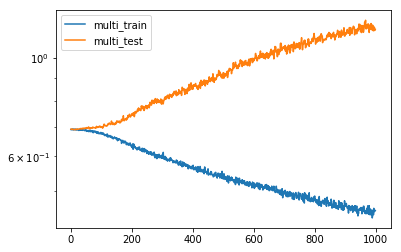

In [140]:
pyplot.plot(history.history['loss'], label='multi_train')
pyplot.plot(history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.yscale('log')
pyplot.show()

regession accuracy:

In [14]:
yhat = model.predict(scaled[-21:-1,:].reshape(20,1,56))
test_y = scaled[-20:,3].reshape(10,1,1)
diff1=np.concatenate((np.ediff1d(test_y[:,0]).reshape(len(test_y[:])-1,1),np.ediff1d(yhat[:,0]).reshape(len(yhat[:])-1,1)),axis=1)
mul = np.multiply(diff1[:,0],diff1[:,1])
print(len(mul[mul>=0])/len(mul))


pred = model.predict(scaled[-2,:].reshape(1,1,56))[0][-1] - scaled[-2,3]
y_test = scaled[-1,3]-scaled[-2,3]
for i in range(1,100):
    pred = np.append(pred, np.array([model.predict(scaled[-2-i,:].reshape(1,1,56))[0][-1]])-scaled[-2-i,3])
    y_test = np.append(y_test, scaled[-1-i,3]-scaled[-2-i,3])
mul = np.multiply(pred, y_test)
len(mul[mul>=0])/len(mul)

ValueError: Error when checking : expected input_2 to have shape (15, 56) but got array with shape (1, 56)

In [20]:
print(model.predict(np.delete(scaled,3,1)[-2,:].reshape(1,1,55))[0][-1])
print(scaled[-1,3])

[ 0.97030538]
1.0


classification accuracy:

In [29]:
pred = model.predict(scaled[-2,:].reshape(1,15,56))[0][-1]
y_test = scaled[-1,3]-scaled[-2,3]
for i in range(1,10):
    pred = np.append(pred, np.array([model.predict(scaled[-2-i,:].reshape(1,15,56))[0][-1]]))
    y_test = np.append(y_test, scaled[-1-i,3]-scaled[-2-i,3])
p=np.empty([len(pred)])                   
for i in range(len(pred)):
    if pred[i] >= 0:
        p[i] = +1.0
    else:
        p[i] = -1.0
mul = np.multiply(p, y_test)
len(mul[mul>=0])/len(mul)

ValueError: cannot reshape array of size 56 into shape (1,15,56)

In [178]:
pred = model.predict(scaled2[-11:-1,:-1].reshape(1,10,14))[0][-1]
y_test = scaled2[-1,3]-scaled2[-2,3]
for i in range(1,15):
    pred = np.append(pred, np.array([model.predict(scaled2[-11-i:-1-i,:-1].reshape(1,10,14))[0][-1]]))
    y_test = np.append(y_test, scaled2[-1-i,3]-scaled2[-2-i,3])
scaler = MinMaxScaler(feature_range=(-1, 1))
#scaler = StandardScaler()
#scaler.fit(y_test.reshape(-1, 1))
#y_test = scaler.transform(y_test.reshape(-1, 1))
#y_test=y_test[:,-1]
#pred = scaler.transform(pred.reshape(-1,1))
#pred = pred[:,-1]
p=np.empty([len(pred)])                   
for i in range(len(pred)):
    if pred[i] >= 0.0:
        p[i] = +1.0
    else:
        p[i] = -1.0
mul = np.multiply(p, y_test)
len(mul[mul>=0])/len(mul)

0.4666666666666667

In [344]:
model.evaluate(test_X,test_y)

20/20 [==============================] - 0s 900us/step


[0.97523295879364014, 0.34999999403953552]

In [345]:
model.predict(test_X)

array([[ 0.44908598,  0.55091399],
       [ 0.31791157,  0.68208849],
       [ 0.9359858 ,  0.0640142 ],
       [ 0.50761443,  0.49238551],
       [ 0.93432957,  0.06567046],
       [ 0.20137239,  0.79862761],
       [ 0.80506045,  0.19493958],
       [ 0.30424833,  0.69575167],
       [ 0.34166884,  0.65833116],
       [ 0.42683479,  0.57316518],
       [ 0.2518304 ,  0.7481696 ],
       [ 0.61474901,  0.38525099],
       [ 0.37301657,  0.6269834 ],
       [ 0.16675115,  0.83324885],
       [ 0.46943262,  0.53056735],
       [ 0.3657099 ,  0.6342901 ],
       [ 0.49318859,  0.50681144],
       [ 0.64690256,  0.35309747],
       [ 0.37790051,  0.62209946],
       [ 0.65741855,  0.34258151]], dtype=float32)

In [328]:
test_y

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

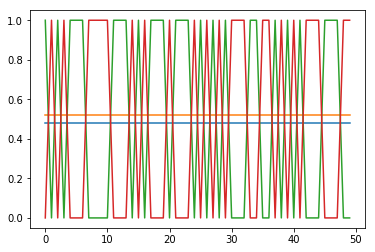

In [141]:
pred = model.predict(test_X)

plt.plot(pred)
plt.plot(test_y)
plt.show()

In [142]:
pred

array([[ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0.4816103,  0.5183897],
       [ 0

In [175]:
pred = model.predict(test_X)
#pred = scaler.inverse_transform(pred.reshape(-1,1))
#pred = pred[:,-1]
p=np.empty([len(pred)])
y_test=np.empty([len(pred)])
for i in range(len(pred)):
    if pred[i,-1] >= 0.5:
        p[i] = +1.0
    else:
        p[i] = -1.0
    if test_y[i]>= 0.5:
        y_test[i] = 1.0
    else:
        y_test[i] = -1.0
mul = np.multiply(p, y_test)
len(mul[mul>=0])/len(mul)

0.52

In [ ]:
pred = model.predict(test_X)
p=[]
for i in range(len(test_X)):
    p.append(pred[i]-test_X[i,3])


In [265]:
pred = model.predict(test_X)
diff1=np.concatenate((np.ediff1d(test_y).reshape(len(test_y)-1,1),np.ediff1d(pred[:,0]).reshape(len(pred[:])-1,1)),axis=1)
mul = np.multiply(diff1[:,0],diff1[:,1])
len(mul[mul>=0])/len(mul)

0.42857142857142855

In [32]:
test_X2 = scaled[-15:-1,:].reshape(1,14,8)
test_y3 = np.array(scaled[-1,-1]-scaled[-2,-1])
for i in range(1, 10):
    test_X2 = np.append(test_X2, scaled[-15-i:-1-i,:].reshape(1,14,8),axis=0)
    test_y3 = np.append(test_y3, np.array(scaled[-1-i,-1]-scaled[-1-i+1,-1]))
test_y2 = np.empty([len(test_y3),2])

for i in range(len(test_y3)):
    if test_y3[i] > 0:
        test_y2[i] = [1,0]
    else:
        test_y2[i] = [0,1]
test_X2.shape, test_y2.shape

((10, 14, 8), (10, 2))

In [57]:
model.predict(scaled2[-16:-1,:].reshape(1,15,56))[0][-1]

0.96497095

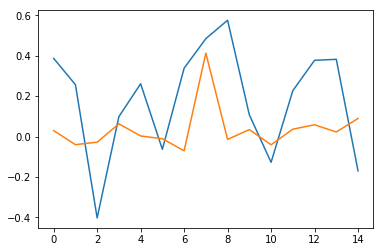

In [93]:
pyplot.plot(pred[-15:].reshape(15,1), label='predict')
pyplot.plot(y_test[-15:])
pyplot.show()

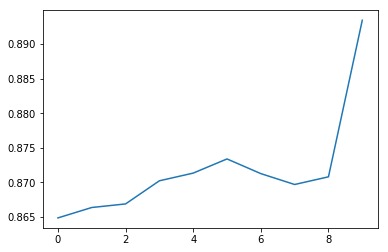

In [17]:
pyplot.plot(model.predict(scaled[-11:-1,:].reshape(10,1,56)).reshape(10))
pyplot.show()

In [131]:
pyplot.plot(np.append(scaled[-10:,-1],model.predict(scaled[-14:].reshape(1,14,4))))
pyplot.show()

ValueError: cannot reshape array of size 22 into shape (1,2,4)

In [79]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, :-2],yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-2:]
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :-2], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-2:]